In [1]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# download ktrain to use the bert model in colab
!pip install ktrain

     |████████████████████████████████| 25.3MB 140kB/s 
     |████████████████████████████████| 6.8MB 56.4MB/s 
     |████████████████████████████████| 983kB 56.1MB/s 
     |████████████████████████████████| 266kB 52.9MB/s 
     |████████████████████████████████| 1.9MB 48.4MB/s 
     |████████████████████████████████| 1.2MB 45.9MB/s 
     |████████████████████████████████| 471kB 48.6MB/s 
     |████████████████████████████████| 870kB 48.3MB/s 
     |████████████████████████████████| 3.3MB 46.4MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.2-cp37-none-any.whl size=25277794 sha256=b780dbaa5f69886db52e85c9aabdeb7506330d6301d1b44f2828e20b45c87348
  Stored in directory: /root/.cache/pip/wheels/67/2e/f1/c72afa08df8b2d984b910dea228902ce81dae4511afe9fafd2
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=0abc63323cc06b3c051f6719360e7a587de3ba4b3e0ea43d5ce3823da65be101
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d4

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
#from nltk.stem.porter import PorterStemmer
import string
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
import ktrain

import re
from tqdm import tqdm
from gensim.models import Word2Vec, KeyedVectors
import pickle
import os

#Importing keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(7)

In [ ]:
nltk.download('wordnet')
nltk.stem.WordNetLemmatizer().lemmatize('word')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


'word'

In [ ]:
# COLAB CONFIG
# change colab flag to false if train using jupyter notebook
COLAB_FLAG = True
COLAB_FILEPATH = './drive/My Drive/4034-amazon-review-classification/' if COLAB_FLAG == True else './'
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

# Pre-processing of data for training the model (Amazon dataset)

### Import training data

In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect(COLAB_FILEPATH + 'data/database.sqlite')
data_train_raw_ = pd.read_sql_query(""" SELECT * FROM Reviews """, con) 
print(data_train_raw_.shape)
data_train_raw_.head(3)

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Filtering of train data

### Remove duplicate entries

In [ ]:
# check duplication of an entry
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [ ]:
#Sorting data according to ProductId in ascending order
data_train_raw=data_train_raw_.sort_values('ProductId', 
                                           axis=0, 
                                           ascending=True, 
                                           inplace=False, 
                                           kind='quicksort', 
                                           na_position='last')

# remove duplication of entries
data_train_raw=data_train_raw.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, 
                                              keep='first', inplace=False)
print(f'Shape: {data_train_raw.shape}')

# Checking to see how much % of data still remains
print(f"percentage of data remains: {(data_train_raw['Id'].size*1.0)/(data_train_raw_['Id'].size*1.0)*100}")
#data_train_raw.head(3)

Shape: (393933, 10)
percentage of data remains: 69.29901100176971


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."


In [ ]:
# sample query
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
# choose data that the helpfulness numerator is higher than the denominator
data_train_raw=data_train_raw[data_train_raw.HelpfulnessNumerator<=data_train_raw.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(data_train_raw.shape)

# distribution of the score of the train data
data_train_raw['Score'].value_counts()

(393931, 10)


5    250966
4     56086
1     36307
3     29772
2     20800
Name: Score, dtype: int64

### Create a training dataframe with only the comments and the ratings

In [ ]:
# create an empty dataframe
data_train = pd.DataFrame()

# to store only the required columns into the new dataframe
data_train['comments'] = data_train_raw['Text']
data_train['ratings'] = data_train_raw['Score']
data_train['type'] = "train"
print(data_train.shape)
print(data_train.dtypes)
data_train.head()

(393931, 3)
comments    object
ratings      int64
type        object
dtype: object


,comments,ratings,type
150528,In June<br />I saw a charming group<br />of ro...,4,train
150506,This is a fun way for children to learn their ...,4,train
150505,"I grew up reading these Sendak books, and watc...",4,train
150504,Get the movie or sound track and sing along wi...,4,train
150503,A very entertaining rhyming story--cleaver and...,4,train


There are 393931 data that we will use to train and validate our model, now we will move on to pre-process our test data, which was scraped from tripadvisor

# Pre-processing the test set (scraped data from tripadvisor)
The goal is to clean the data of the test set so that the both datasets have the same columns

### Import test data

In [ ]:
# read the test data
data_test_raw_ = pd.read_csv(COLAB_FILEPATH+'data/trip-advisor-comments.csv')
print(f'Shape of the dataset:{data_test_raw_.shape}')
#data_test_raw_.head()

Shape of the dataset:(97190, 5)


### Filtering of the test data

In [ ]:
# remove duplication of entries
data_test_raw=data_test_raw_.drop_duplicates(subset={"Reviewer\'s Name","Comment"}, 
                                             keep='first', inplace=False)
print(f'Shape of the dataset after removing duplicates:{data_test_raw.shape}')
#data_test_raw.head()

Shape of the dataset after removing duplicates:(88042, 5)


In [ ]:
# total number of words
no_words = 0
k = list(data_test_raw['Comment'].str.count(' ') + 1)
for i in k:
    no_words += i
print(f'Number of words: {no_words}')

# total number of unique words
uniqueWords = list(set(" ".join(data_test_raw['Comment'].values).split(" ")))
count = len(uniqueWords)
print(f'Number of unique words: {count}')

data_test_raw.head(3)

Number of words: 3688240
Number of unique words: 137499


,Restaurant Name,Restaurant Type,Reviewer's Name,Rating,Comment
0,Positano @ RP,"Italian, European",aisvslife98,5,I enjoyed my time here with my girlfriends! Fa...
1,Positano @ RP,"Italian, European",Odyssey44198198885,5,Wonderful and amazing service experience. Defi...
2,Positano @ RP,"Italian, European",Ninifazelin,5,Great food and wonderful service! Will definit...


In [ ]:
#Checking to see how much % of data still remains after removing duplications
(data_test_raw['Reviewer\'s Name'].size*1.0)/(data_test_raw_['Reviewer\'s Name'].size*1.0)*100

90.58750900298385

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(data_test_raw.shape)

# distribution of the score of the test data
data_test_raw['Rating'].value_counts()

(88042, 5)


5    46304
4    25976
3     8837
1     3464
2     3461
Name: Rating, dtype: int64

In [ ]:
# export the filtered test data for SOLR
data_test_raw.to_csv(COLAB_FILEPATH + 'data/trip-advisor-comments-filtered.csv', index=False)

In [ ]:
data_test_raw = pd.read_csv(COLAB_FILEPATH + 'data/trip-advisor-comments-filtered.csv')
# create an empty dataframe
data_test = pd.DataFrame()

# to store only the required columns into the new dataframe
data_test['Restaurant Name'] = data_test_raw['Restaurant Name']
data_test['Restaurant Type'] = data_test_raw['Restaurant Type']
data_test['Reviewer\'s Name'] = data_test_raw['Reviewer\'s Name']
data_test['comments'] = data_test_raw['Comment']
data_test['ratings'] = data_test_raw['Rating']
data_test['type'] = "test"
print(data_test.shape)
print(data_test.dtypes)
data_test.head()

(88042, 6)
Restaurant Name    object
Restaurant Type    object
Reviewer's Name    object
comments           object
ratings             int64
type               object
dtype: object


,Restaurant Name,Restaurant Type,Reviewer's Name,comments,ratings,type
0,Positano @ RP,"Italian, European",aisvslife98,I enjoyed my time here with my girlfriends! Fa...,5,test
1,Positano @ RP,"Italian, European",Odyssey44198198885,Wonderful and amazing service experience. Defi...,5,test
2,Positano @ RP,"Italian, European",Ninifazelin,Great food and wonderful service! Will definit...,5,test
3,Positano @ RP,"Italian, European",Amaliamazlan,Not my first time in Positano and definitely w...,5,test
4,Positano @ RP,"Italian, European",Shahzanstim,Excellent service from the staff. The beef was...,5,test


# Partition the ratings to 3 classes only
-1 (negative) <- 1,2  
0 (neutral) <- 3  
1 (positive) <- 4,5


In [ ]:
def partition(x):
    if x < 3:
        return -1
    elif x == 3:
        return 0
    else:   
        return 1

In [ ]:
# append partitioned data to the train set
actualScore = data_train['ratings']
class_ = actualScore.map(partition) 
data_train['ratings_class'] = class_
print("Number of data points in train data", data_train.shape)
data_train.head(3)

Number of data points in train data (393931, 4)


,comments,ratings,type,ratings_class
150528,In June<br />I saw a charming group<br />of ro...,4,train,1
150506,This is a fun way for children to learn their ...,4,train,1
150505,"I grew up reading these Sendak books, and watc...",4,train,1


In [ ]:
# append partitioned data to the test set
actualScore = data_test['ratings']
class_ = actualScore.map(partition) 
data_test['ratings_class'] = class_
print("Number of data points in test data", data_test.shape)
data_test.head(3)

Number of data points in test data (88042, 7)


,Restaurant Name,Restaurant Type,Reviewer's Name,comments,ratings,type,ratings_class
0,Positano @ RP,"Italian, European",aisvslife98,I enjoyed my time here with my girlfriends! Fa...,5,test,1
1,Positano @ RP,"Italian, European",Odyssey44198198885,Wonderful and amazing service experience. Defi...,5,test,1
2,Positano @ RP,"Italian, European",Ninifazelin,Great food and wonderful service! Will definit...,5,test,1


In [ ]:
# check the number of data in each ratings_class
data_train['ratings_class'].value_counts()

 1    307052
-1     57107
 0     29772
Name: ratings_class, dtype: int64

Got data imbalance, need to do downsampling AFTER separating neutral data from opinionated ones

### Separate neutral data from opinionated ones
Look at the ratings_class column:  
1, -1 -> opinionated  
0 -> neutral

In [ ]:
# neutral train data
data_neutral_train = data_train[data_train['ratings_class'] == 0]
print(data_neutral_train.shape)
#data_neutral_train.head(3)

(29772, 4)


In [ ]:
# neutral test data
data_neutral_test = data_test[data_test['ratings_class'] == 0]
print(data_neutral_test.shape)
#data_neutral_test.head(3)

(8837, 7)


In [ ]:
# take a look at the neutral data (train)
print(data_neutral_train['comments'].iloc[1])
print(data_neutral_train['comments'].iloc[3])
print(data_neutral_train['comments'].iloc[50])

This book was purchased to be used in a classroom setting for read-a-loud purposes.  The small size of the book(4X6)makes that almost impossible.  The book itself is very cute and flows nicely, but is best shared with only one child at a time.
My dog enjoys these treats in moderation.  Because they are dried, he seems to enjoy them less the more he eats them.  With water, the treats may be much more flavorful.  After having a fair amount, he starts to lose interest in them until he can drink.<br /><br />This brings me to a question regarding serving size.  The container recommends 2-3 cubes per day for a medium breed.  The issue I'm having is that the size of the cubes is so very inconsistent.  Some bits are the size of a pea while others of a grape.  The rest are a variety of sizes in between.  Some consistency would be preferred.<br /><br />Also, this product comes highly recommended for training because it is low in fat.  My dog certainly won't learn anything with just 2-3 of these 

In [ ]:
# take a look at the neutral data (test)
print(data_neutral_test['comments'].iloc[1])
print(data_neutral_test['comments'].iloc[3])
print(data_neutral_test['comments'].iloc[50])

We visited Entre-Nous creperie just now, not entirely crowded with decent crowd but we waited almost 40 minutes for our crepes, one banana and another salted butter caramel to be served. I counted 3 chefs in the kitchen and one lady waitress serving.

Conclusion, the 
Food was not bad and service was good. However, there was a birthday function held at the general dinning area (not in a private room as there were many tables) and it was very noisy. Would have given a 4 star if not of this .
l was under the illusion that there is no need to make reservationsoo when eating out because of covid 19 restrictions.I was very wrong. On thu l tried to make reservations at Koma for two for dinner the next day. First available time is 9.45pm .


In [ ]:
# got data imbalance, need to downsample
# check the number of data in each ratings_class
data_train['ratings_class'].value_counts()

 1    307052
-1     57107
 0     29772
Name: ratings_class, dtype: int64

### Downsample the positive class in the training set (ONLY the training set!) to balance out with the negative class in terms of document count

In [ ]:
# data with class -1
data_negative_train = data_train[data_train['ratings_class'] == -1]
print(data_negative_train.shape)
data_negative_train.head(3)

(57107, 4)


,comments,ratings,type,ratings_class
150496,I give five stars to the Maurice Sendak story....,1,train,-1
150525,This is one of the best children's books ever ...,1,train,-1
24749,My dogs loves this chicken but its a product f...,2,train,-1


In [ ]:
# data with class 1, sample with the total number of entries in the negative class (downsampling)
data_positive_train = data_train[data_train['ratings_class'] == 1].sample(len(data_negative_train), replace=False)
print(data_positive_train.shape)
data_positive_train.head(3)

(57107, 4)


,comments,ratings,type,ratings_class
198912,I was looking for Mag Citrate in a fast-acting...,5,train,1
231943,"My daughter is egg, soy, peanut, tree nut, ses...",5,train,1
415336,This drink ***SLURP*** is soo good! I am drink...,5,train,1


In [ ]:
# concatenate the positive and negative data into a new dataframe
# this dataframe will be the training set (amazon dataset) for our test set (crawled corpus)
data_train_undersampled_ = pd.concat([data_negative_train, data_positive_train])
# randomise the order of the sampled dataframe
data_train_undersampled = data_train_undersampled_.sample(frac=1)
print(data_train_undersampled.shape)
data_train_undersampled.head()

(114214, 4)


,comments,ratings,type,ratings_class
214595,This maple syrup was very good. I was very di...,2,train,-1
97297,I cant believe my favorite type of chocacolate...,5,train,1
46253,The noodles were better than I thought instant...,2,train,-1
228596,I think I ordered the wrong brand. Peter Pan c...,2,train,-1
102453,"My bulldog does so well on this food, I doubt ...",5,train,1


In [ ]:
# check the distribution of the class again
data_train_undersampled['ratings_class'].value_counts()

-1    57107
 1    57107
Name: ratings_class, dtype: int64

In [ ]:
# get the length of train data for later use
train_data_length = len(data_train_undersampled)
train_data_length

114214

### Preprocess the test dataset to separate the neutral data from the opinionated ones
So that we can fit the test set into the binary classifier model trained

In [ ]:
data_opinionated_test = data_test[data_test['ratings_class'] != 0]
print(data_opinionated_test.shape)
print(data_opinionated_test['ratings_class'].value_counts())

(79205, 7)
 1    72280
-1     6925
Name: ratings_class, dtype: int64


**Summary of dataframes formed**  
- data_neutral_train  
- data_neutral_test
- data_train_undersampled (positive + negative)
- data_opinionated_test (positive + negative)
- data_test_ordered (positive + negative + neutral at the back) for SOLR

In [ ]:
frames = [data_opinionated_test, data_neutral_test]
data_test_ordered = pd.concat(frames)
# check the dimension of the merged dataframe
print(data_test_ordered.shape)
#data_test_ordered.head(3)
data_test_ordered['ratings_class'].value_counts()

(88042, 7)


 1    72280
 0     8837
-1     6925
Name: ratings_class, dtype: int64

There are 8837 comments that are neutral at the back of the dataframe

In [ ]:
# combine the test set for later use in SOLR
data_test_ordered.to_csv(COLAB_FILEPATH + 'data/trip-advisor-comments-filtered-ordered.csv', index=False)

In [ ]:
# drop the unwanted columns so that it can be merged with the train set
data_opinionated_test = data_opinionated_test.drop(['Restaurant Name','Restaurant Type', 'Reviewer\'s Name'], axis=1)
data_opinionated_test.head(3)

,comments,ratings,type,ratings_class
0,I enjoyed my time here with my girlfriends! Fa...,5,test,1
1,Wonderful and amazing service experience. Defi...,5,test,1
2,Great food and wonderful service! Will definit...,5,test,1


# Merge 2 dataframes together
Take note of the last entry of the train set and the first entry of the test set so that we can split the dataset to train-val and test set after tokenization

In [ ]:
# shape of train set
print(f'Train set dimension: {data_train_undersampled.shape}')
# shape of test set
print(f'Test set dimension: {data_opinionated_test.shape}')

Train set dimension: (114214, 4)
Test set dimension: (79205, 4)


### Perform data cleaning and Lemmatization

In [ ]:
# merge the 2 dataframes together to perform tokenization
frames = [data_train_undersampled,data_opinionated_test]
data_overall = pd.concat(frames)
# check the dimension of the merged dataframe
print(data_overall.shape)
data_overall.head(3)

(193419, 4)


,comments,ratings,type,ratings_class
214595,This maple syrup was very good. I was very di...,2,train,-1
97297,I cant believe my favorite type of chocacolate...,5,train,1
46253,The noodles were better than I thought instant...,2,train,-1


In [ ]:
# check the range where the data changes from train set to test set
# debug
#data_overall.iloc[:,:]
# finding the split
data_overall.iloc[train_data_length-2:train_data_length+2,:]

,comments,ratings,type,ratings_class
534782,I only ordered this MFG brand of lingonberry b...,1,train,-1
48580,I got a sample of this in my Summer VoxBox and...,5,train,1
0,I enjoyed my time here with my girlfriends! Fa...,5,test,1
1,Wonderful and amazing service experience. Defi...,5,test,1


In [ ]:
# last entry of the train set
data_overall.iloc[[train_data_length-1]]

,comments,ratings,type,ratings_class
48580,I got a sample of this in my Summer VoxBox and...,5,train,1


In [ ]:
data_overall.head()

,comments,ratings,type,ratings_class
214595,This maple syrup was very good. I was very di...,2,train,-1
97297,I cant believe my favorite type of chocacolate...,5,train,1
46253,The noodles were better than I thought instant...,2,train,-1
228596,I think I ordered the wrong brand. Peter Pan c...,2,train,-1
102453,"My bulldog does so well on this food, I doubt ...",5,train,1


# Perform data cleaning and Lemmatization

In [ ]:
# remove contractions
def contraction_removal(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", "not", phrase)
    phrase = re.sub(r"\'re", "are", phrase)
    phrase = re.sub(r"\'s", "is", phrase)
    phrase = re.sub(r"\'d", "would", phrase)
    phrase = re.sub(r"\'ll", "will", phrase)
    phrase = re.sub(r"\'t", "not", phrase)
    phrase = re.sub(r"\'ve", "have", phrase)
    phrase = re.sub(r"\'m", "am", phrase)
    return phrase

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "\n"])

In [ ]:
# to do data cleaning here
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(data_overall['comments'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = contraction_removal(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 193419/193419 [00:57<00:00, 3389.84it/s]


In [ ]:
# perform lemmatization here
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df = pd.DataFrame(preprocessed_reviews, columns=['text'])
df['text_lemmatized'] = df.text.apply(lemmatize_text)
df.head()

,text,text_lemmatized
0,maple syrup good disheartened find mold bottom...,"[maple, syrup, good, disheartened, find, mold,..."
1,cant believe favorite type chocacolate sold lo...,"[cant, believe, favorite, type, chocacolate, s..."
2,noodles better thought instant rice noodles wo...,"[noodle, better, thought, instant, rice, noodl..."
3,think ordered wrong brand peter pan creamy tex...,"[think, ordered, wrong, brand, peter, pan, cre..."
4,bulldog well food doubt ever switch helped tre...,"[bulldog, well, food, doubt, ever, switch, hel..."


In [ ]:
text_lemmatized_list = []
# merge the elements in the list into a string
for i in df['text_lemmatized']:
    listToStr = ' '.join([str(elem) for elem in i])
    text_lemmatized_list.append(listToStr)

In [ ]:
# append the lemmatized list to the main dataframe
data_overall['comments_cleaned'] = text_lemmatized_list
print(data_overall.shape)
data_overall.head()

(193419, 5)


,comments,ratings,type,ratings_class,comments_cleaned
214595,This maple syrup was very good. I was very di...,2,train,-1,maple syrup good disheartened find mold bottom...
97297,I cant believe my favorite type of chocacolate...,5,train,1,cant believe favorite type chocacolate sold lo...
46253,The noodles were better than I thought instant...,2,train,-1,noodle better thought instant rice noodle woul...
228596,I think I ordered the wrong brand. Peter Pan c...,2,train,-1,think ordered wrong brand peter pan creamy tex...
102453,"My bulldog does so well on this food, I doubt ...",5,train,1,bulldog well food doubt ever switch helped tre...


### Export cleaned corpus to csv  
To save the progress of the data cleaning at this point of time


In [ ]:
data_overall.to_csv(COLAB_FILEPATH + 'data/data_train_test_combined.csv', 
                    index=False)

### Import the cleaned corpus

In [ ]:
data_overall_ = pd.read_csv(COLAB_FILEPATH + 'data/data_train_test_combined.csv')
data_overall_.head()

,comments,ratings,type,ratings_class,comments_cleaned
0,This maple syrup was very good. I was very di...,2,train,-1,maple syrup good disheartened find mold bottom...
1,I cant believe my favorite type of chocacolate...,5,train,1,cant believe favorite type chocacolate sold lo...
2,The noodles were better than I thought instant...,2,train,-1,noodle better thought instant rice noodle woul...
3,I think I ordered the wrong brand. Peter Pan c...,2,train,-1,think ordered wrong brand peter pan creamy tex...
4,"My bulldog does so well on this food, I doubt ...",5,train,1,bulldog well food doubt ever switch helped tre...


In [ ]:
print(data_overall_.dtypes)
print(data_overall_.count())

comments            object
ratings              int64
type                object
ratings_class        int64
comments_cleaned    object
dtype: object
comments            193419
ratings             193419
type                193419
ratings_class       193419
comments_cleaned    193129
dtype: int64


In [ ]:
# replace na with - for the row where the comments cleaned are empty
data_overall_['comments_cleaned'] = data_overall_['comments_cleaned'].fillna('-')
data_overall_.count()

comments            193419
ratings             193419
type                193419
ratings_class       193419
comments_cleaned    193419
dtype: int64

In [ ]:
# remove not useful columns
data_overall = data_overall_.drop(labels='comments', axis=1)
data_overall = data_overall.drop(labels='ratings', axis=1)
data_overall.head(10)

,type,ratings_class,comments_cleaned
0,train,-1,maple syrup good disheartened find mold bottom...
1,train,1,cant believe favorite type chocacolate sold lo...
2,train,-1,noodle better thought instant rice noodle woul...
3,train,-1,think ordered wrong brand peter pan creamy tex...
4,train,1,bulldog well food doubt ever switch helped tre...
5,train,1,french country spread itis best creamiest text...
6,train,1,best bar ever would eat one every day could fl...
7,train,1,really like flavor little little milk wonderfu...
8,train,-1,bargain price still could tasted better carame...
9,train,1,dog yorkshire terrier mouth small ihave fed bi...


In [ ]:
# check the range where the data changes from train set to test set
# count number of dataset that belongs to train
train_count = data_overall['type'].value_counts()['train']
train_count

114214

In [ ]:
# finding the split
data_overall.iloc[train_count-2:train_count+2,:]

,type,ratings_class,comments_cleaned
114212,train,-1,ordered mfg brand lingonberry advertised lingo...
114213,train,1,got sample summer voxbox fell immediately love...
114214,test,1,enjoyed time girlfriend fajar server gave reco...
114215,test,1,wonderful amazing service experience definitel...


In [ ]:
print(data_overall.iloc[train_count-1,2])
print(len(data_overall[data_overall['type']=='test']))

got sample summer voxbox fell immediately love wrapper suggested heating microwave second let tell fantastic definitely buying regular basis
79205


# Label and define the predictor and the response

In [ ]:
X = data_overall['comments_cleaned'].values
y = data_overall['ratings_class']
# one hot the classifier
y_oh = pd.get_dummies(y)
# check the one-hot classifier
y_oh[:3]

,-1,1
0,1,0
1,0,1
2,1,0


In [ ]:
X

array(['maple syrup good disheartened find mold bottom bottle last serving didnot think mold formed maple syrup gross',
       'cant believe favorite type chocacolate sold low price ihave checked website website aero bar cost knew could find lower price amazing deal one best chocolate bar around highly recommend order least',
       'noodle better thought instant rice noodle would said positive think rice noodle bland expected much flavorful soup little flavor could make soup wasnot good didnot fit description chinese onion flavor mean something significantly different onion flavor ignore would not connected onion unless read package iam not sure describe little taste thatis taste bad',
       ...,
       'nice spacious restaurant sunlight thru roof cool nice place relax buffet spread variety dish japanese cuisine northern indian western roast beef pork asian local favourite like laksa crayfish seafood spread covering',
       'restraunt replaces cafe swiss location chef diff name good

In [ ]:
X_df = pd.DataFrame(X)
X_df.columns = ["cleaned_comments"]
X_df.head()

,cleaned_comments
0,maple syrup good disheartened find mold bottom...
1,cant believe favorite type chocacolate sold lo...
2,noodle better thought instant rice noodle woul...
3,think ordered wrong brand peter pan creamy tex...
4,bulldog well food doubt ever switch helped tre...


In [ ]:
# Count the Vocabulary
count_vect = CountVectorizer()
count_vect.fit(X)

vocabulary = count_vect.get_feature_names()
print('Words in the Vocabulary : ',len(vocabulary))

Words in the Vocabulary :  78815


# Pre-processing of text by doing tokenization of data

In [ ]:
#Creating dictionary
corpus = dict()
ind = 0
for sent in X:
  for word in sent.split():
    corpus.setdefault(word,[])
    corpus[word].append(ind)
    ind += 1

#Frequency for each word of vocabulary
freq = []
for w in vocabulary:
  #print(w, end=' ')
  freq.append(len(corpus[w]))

In [ ]:
#Frequencies in decreasing order
inc_index =np.argsort(np.array(freq))[::-1]

#Allocating ranks 
word_rank = dict()
rank = 1
for i in inc_index:
  word_rank[vocabulary[i]] = rank
  rank +=1

In [ ]:
data = []
for sent in X:
  row = []
  for word in sent.split():
    if(len(word)>1):
      row.append(word_rank[word])
  data.append(row)

In [ ]:
# check the tokenized representation
print(data[train_count-1], end= ' ')

[75, 978, 1151, 9336, 1471, 709, 14, 1731, 1355, 3685, 970, 265, 346, 413, 303, 94, 180, 201, 1677] 

In [ ]:
# splitting of data
X_train, X_test = data[:train_count], data[train_count:]
Y_train, Y_test = y[:train_count], y[train_count:]
Y_train_oh , Y_test_oh = y_oh[:train_count], y_oh[train_count:]

# Deep Learning Portion

In [ ]:
# padding input sequences
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[2000])

(114214, 100)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  195  211  169  164  532  547  862 1890   89 1951
 1296  479   90   56    9  185  466  238   28    1  965   77  724   68
    9 4089]


In [ ]:
# plot function for the accuracy and loss curve
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid(True)
    fig.canvas.draw()

### LSTM One Layer

In [ ]:
vocab_size = len(vocabulary)
embedding_vector_length = 32
EPOCHS = 5

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vector_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           2522112   
_________________________________________________________________
dropout (Dropout)            (None, 100, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 2,604,802
Trainable params: 2,604,802
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
callbacks_list=[ModelCheckpoint(filepath=COLAB_FILEPATH+'model/LSTM-1layer-2-class-downsampled.h5',save_best_only=True,verbose=1,)]
#Fitting the data to the model
history = model.fit(X_train, 
                    Y_train_oh, 
                    epochs=EPOCHS, 
                    batch_size=512,
                    verbose=1,
                    #validation_data=(X_test, Y_test),
                    validation_split=0.2,
                    callbacks=callbacks_list)

Epoch 1/5
179/179 [==============================] - 13s 49ms/step - loss: 0.5557 - accuracy: 0.6978 - val_loss: 0.2850 - val_accuracy: 0.8847

Epoch 00001: val_loss improved from inf to 0.28496, saving model to ./drive/My Drive/4034-amazon-review-classification/model/LSTM-1layer-2-class-downsampled.h5
Epoch 2/5
179/179 [==============================] - 8s 42ms/step - loss: 0.2537 - accuracy: 0.8997 - val_loss: 0.2745 - val_accuracy: 0.8895

Epoch 00002: val_loss improved from 0.28496 to 0.27454, saving model to ./drive/My Drive/4034-amazon-review-classification/model/LSTM-1layer-2-class-downsampled.h5
Epoch 3/5
179/179 [==============================] - 8s 43ms/step - loss: 0.2137 - accuracy: 0.9176 - val_loss: 0.2869 - val_accuracy: 0.8859

Epoch 00003: val_loss did not improve from 0.27454
Epoch 4/5
179/179 [==============================] - 8s 43ms/step - loss: 0.1840 - accuracy: 0.9305 - val_loss: 0.2837 - val_accuracy: 0.8881

Epoch 00004: val_loss did not improve from 0.27454
E

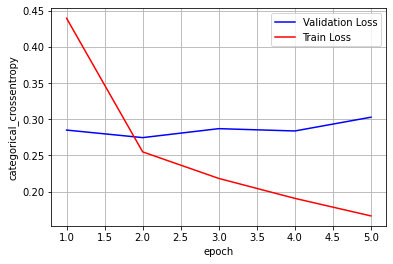

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('categorical_crossentropy')

# list of epoch numbers
x = list(range(1,EPOCHS+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [ ]:
import time

start = time.perf_counter()
# evaluate model with test set (crawled data)
model_lstm_1layer = tensorflow.keras.models.load_model(COLAB_FILEPATH+'model/LSTM-1layer-2-class-downsampled.h5')
time_taken = time.perf_counter()-start
time_taken

0.4348519060000058

In [ ]:
# accuracy on test data
start = time.perf_counter()
score_1layer = model_lstm_1layer.evaluate(X_test,Y_test_oh, verbose=0)
time_taken = time.perf_counter()-start
print('Test loss:', score_1layer[0])
print('Test accuracy:', score_1layer[1])
print(time_taken/len(X_test))
print(len(X_test)/time_taken)

Test loss: 0.20734244585037231
Test accuracy: 0.9185531139373779
0.00010680404403762343
9362.941347499294


In [ ]:
# predict rating for the test data
Y_pred_dist_test = model_lstm_1layer.predict(X_test)
Y_pred_test = Y_pred_dist_test.argmax(axis=1)+1
print('Y_pred_test.shape:',Y_pred_test.shape)

# see the unique classes in the ground truth
print('Unqiue classes in the ground truth:',np.unique(Y_test))
print('GROUND TRUTH')
print(np.count_nonzero(Y_test == -1))
print(np.count_nonzero(Y_test == 1))

# see the unique classes in the prediction
print('Unqiue classes in the prediction:',np.unique(Y_pred_test))
print('PREDICTION')
print(np.count_nonzero(Y_pred_test == 1))
print(np.count_nonzero(Y_pred_test == 2))

#check if length the same for ground truth and prediction
print(len(Y_test) == len(Y_pred_test))

# map the prediction class from 1,2 to -1 and 1
Y_pred_test = np.where(Y_pred_test == 1, -1, Y_pred_test)
Y_pred_test = np.where(Y_pred_test == 2, 1, Y_pred_test)
print('Unqiue classes in the prediction after mapping:',np.unique(Y_pred_test))

Y_pred_test.shape: (79205,)
Unqiue classes in the ground truth: [-1  1]
GROUND TRUTH
6925
72280
Unqiue classes in the prediction: [1 2]
PREDICTION
8338
70867
True
Unqiue classes in the prediction after mapping: [-1  1]


In [ ]:
# F1-score for binary classifier
target_names = ['-1', '1']
print(classification_report(Y_test.tolist(), Y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

          -1       0.53      0.64      0.58      6925
           1       0.96      0.95      0.95     72280

    accuracy                           0.92     79205
   macro avg       0.75      0.79      0.77     79205
weighted avg       0.93      0.92      0.92     79205



In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_arr = confusion_matrix(Y_test, Y_pred_test)
cm_arr

array([[ 4406,  2519],
       [ 3932, 68348]])

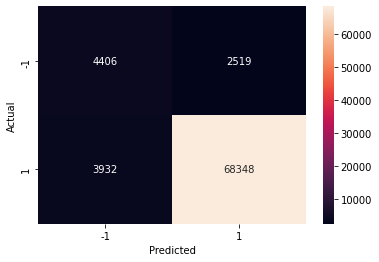

In [ ]:
cm_sns = pd.crosstab(Y_test, Y_pred_test, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(cm_sns, annot=True, fmt="d")
plt.show()

In [ ]:
# ROC-AUC - 1 layer lstm
# Area under curve (AUC)
fpr_keras_1lstm, tpr_keras_1lstm, thresholds_keras_1lstm = roc_curve(Y_pred_test, Y_test)
auc_keras_1lstm = auc(fpr_keras_1lstm, tpr_keras_1lstm)
auc_keras_1lstm

0.7464393120599496

# --- This section is for SOLR indexing system ---

In [ ]:
Y_pred_test[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
len(Y_pred_test)

79205

In [ ]:
Y_test.to_numpy()[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
# load the test data file
df_solr_ = pd.read_csv(COLAB_FILEPATH + 'data/trip-advisor-comments-filtered-ordered.csv')
df_solr_.head(2)

,Restaurant Name,Restaurant Type,Reviewer's Name,comments,ratings,type,ratings_class
0,Positano @ RP,"Italian, European",aisvslife98,I enjoyed my time here with my girlfriends! Fa...,5,test,1
1,Positano @ RP,"Italian, European",Odyssey44198198885,Wonderful and amazing service experience. Defi...,5,test,1


In [ ]:
# rename header
df_solr = df_solr_.rename(columns = {'ratings_class': 'true_label'}, inplace = False)
df_solr.head(2)

,Restaurant Name,Restaurant Type,Reviewer's Name,comments,ratings,type,true_label
0,Positano @ RP,"Italian, European",aisvslife98,I enjoyed my time here with my girlfriends! Fa...,5,test,1
1,Positano @ RP,"Italian, European",Odyssey44198198885,Wonderful and amazing service experience. Defi...,5,test,1


In [ ]:
df_solr['true_label'].value_counts()

 1    72280
 0     8837
-1     6925
Name: true_label, dtype: int64

In [ ]:
# check the difference in length
diff_len = len(df_solr['true_label'])-len(Y_pred_test)
diff_len == len(data_neutral_test)

True

In [ ]:
# save the prediction into the dataframe
test_data['pred_label'] = np.append(Y_pred_test,[0]*diff_len)
test_data.head(5)

,Restaurant Name,Restaurant Type,Reviewer's Name,comments,ratings,type,ratings_class,pred_label
0,Positano @ RP,"Italian, European",aisvslife98,I enjoyed my time here with my girlfriends! Fa...,5,test,1,1
1,Positano @ RP,"Italian, European",Odyssey44198198885,Wonderful and amazing service experience. Defi...,5,test,1,1
2,Positano @ RP,"Italian, European",Ninifazelin,Great food and wonderful service! Will definit...,5,test,1,1
3,Positano @ RP,"Italian, European",Amaliamazlan,Not my first time in Positano and definitely w...,5,test,1,1
4,Positano @ RP,"Italian, European",Shahzanstim,Excellent service from the staff. The beef was...,5,test,1,1


In [ ]:
# shuffle the indexes in the dataframe
test_data_shuffled = test_data.sample(frac=1).reset_index(drop=True)
test_data_shuffled.head()

,Restaurant Name,Restaurant Type,Reviewer's Name,comments,ratings,type,ratings_class,pred_label
0,DC Comics Super Heroes Cafe,"Diner, American",Julzwellery,Overall food was good and nice worth the price...,3,test,0,0
1,Candlenut,"Asian, Singaporean",IonaC560314,Our Daughter and her husband wanted to treat m...,5,test,1,1
2,Man Man Japanese Unagi Restaurant,$$ - $$$,nicholasy814,1st time at the restuarant. Will to the branc...,5,test,1,1
3,La Braceria Pizza & Grill,"Italian, Pizza",carlosg301,Went with my daughter and wife.\n\nThe burrata...,5,test,1,1
4,Shisen Hanten,"Chinese, Asian",chungsenggoh,"For restaurant of your recognition, the experi...",1,test,-1,-1


In [ ]:
# export final data with the prediction into the csv
test_data_shuffled.to_csv(COLAB_FILEPATH + 'data/data_for_solr_updated.csv', index=False)

# --- Code for SOLR ends ---

### Bi-directional LSTM

In [ ]:
vocab_size = len(vocabulary)
embedding_vector_length = 32
EPOCHS = 5

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vector_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 32)           2522112   
_________________________________________________________________
dropout_12 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               164864    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 514       
Total params: 2,687,490
Trainable params: 2,687,490
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
callbacks_list=[ModelCheckpoint(filepath=COLAB_FILEPATH+'model/BiLSTM-1layer-2-class-downsampled.h5',save_best_only=True,verbose=1,)]
#Fitting the data to the model
history = model.fit(X_train, 
                    Y_train_oh, 
                    epochs=EPOCHS, 
                    batch_size=512,
                    verbose=1,
                    #validation_data=(X_test, Y_test),
                    validation_split=0.2,
                    callbacks=callbacks_list)

Epoch 1/5
179/179 [==============================] - 14s 64ms/step - loss: 0.5156 - accuracy: 0.7135 - val_loss: 0.2885 - val_accuracy: 0.8820

Epoch 00001: val_loss improved from inf to 0.28847, saving model to ./drive/My Drive/4034-amazon-review-classification/model/BiLSTM-1layer-2-class-downsampled.h5
Epoch 2/5
179/179 [==============================] - 11s 59ms/step - loss: 0.2475 - accuracy: 0.9027 - val_loss: 0.2798 - val_accuracy: 0.8896

Epoch 00002: val_loss improved from 0.28847 to 0.27981, saving model to ./drive/My Drive/4034-amazon-review-classification/model/BiLSTM-1layer-2-class-downsampled.h5
Epoch 3/5
179/179 [==============================] - 11s 60ms/step - loss: 0.2082 - accuracy: 0.9200 - val_loss: 0.2811 - val_accuracy: 0.8863

Epoch 00003: val_loss did not improve from 0.27981
Epoch 4/5
179/179 [==============================] - 11s 59ms/step - loss: 0.1817 - accuracy: 0.9313 - val_loss: 0.2854 - val_accuracy: 0.8845

Epoch 00004: val_loss did not improve from 0.

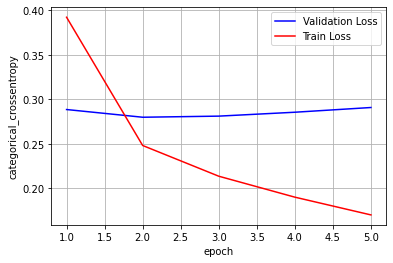

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('categorical_crossentropy')

# list of epoch numbers
x = list(range(1,EPOCHS+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [ ]:
# evaluate model with test set
start = time.perf_counter()
model_bilstm_1layer = tensorflow.keras.models.load_model(COLAB_FILEPATH+'model/BiLSTM-1layer-2-class-downsampled.h5')
time_taken = time.perf_counter()-start
time_taken

1.308147745000042

In [ ]:
start = time.perf_counter()
# accuracy on test data
score_bi1layer = model_bilstm_1layer.evaluate(X_test,Y_test_oh, verbose=0)
time_taken = time.perf_counter()-start
print('Test loss:', score_bi1layer[0])
print('Test accuracy:', score_bi1layer[1])
print(time_taken/len(X_test))
print(len(X_test)/time_taken)

Test loss: 0.2019120156764984
Test accuracy: 0.9199040532112122
0.00017166389325168867
5825.336831513129


In [ ]:
# predict rating for the test data
Y_pred_dist_test = model_bilstm_1layer.predict(X_test)
Y_pred_test = Y_pred_dist_test.argmax(axis=1)+1
print('Y_pred_test.shape:',Y_pred_test.shape)

# see the unique classes in the ground truth
print('Unqiue classes in the ground truth:',np.unique(Y_test))
print('GROUND TRUTH')
print(np.count_nonzero(Y_test == -1))
print(np.count_nonzero(Y_test == 1))

# see the unique classes in the prediction
print('Unqiue classes in the prediction:',np.unique(Y_pred_test))
print('PREDICTION')
print(np.count_nonzero(Y_pred_test == 1))
print(np.count_nonzero(Y_pred_test == 2))

#check if length the same for ground truth and prediction
print(len(Y_test) == len(Y_pred_test))

# map the prediction class from 1,2 to -1 and 1
Y_pred_test = np.where(Y_pred_test == 1, -1, Y_pred_test)
Y_pred_test = np.where(Y_pred_test == 2, 1, Y_pred_test)
print('Unqiue classes in the prediction after mapping:',np.unique(Y_pred_test))

Y_pred_test.shape: (79205,)
Unqiue classes in the ground truth: [-1  1]
GROUND TRUTH
6925
72280
Unqiue classes in the prediction: [1 2]
PREDICTION
8003
71202
True
Unqiue classes in the prediction after mapping: [-1  1]


In [ ]:
# F1-score for binary classifier
target_names = ['-1', '1']
print(classification_report(Y_test.tolist(), Y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

          -1       0.54      0.62      0.58      6925
           1       0.96      0.95      0.96     72280

    accuracy                           0.92     79205
   macro avg       0.75      0.78      0.77     79205
weighted avg       0.93      0.92      0.92     79205



In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_arr = confusion_matrix(Y_test, Y_pred_test)
cm_arr

array([[ 4292,  2633],
       [ 3711, 68569]])

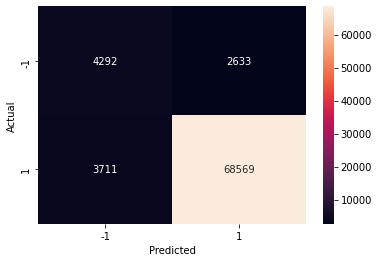

In [ ]:
cm_sns = pd.crosstab(Y_test, Y_pred_test, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(cm_sns, annot=True, fmt="d")
plt.show()

In [ ]:
# ROC-AUC - bilstm
# Area under curve (AUC)
fpr_keras_bilstm, tpr_keras_bilstm, thresholds_keras_bilstm = roc_curve(Y_pred_test, Y_test)
auc_keras_bilstm = auc(fpr_keras_bilstm, tpr_keras_bilstm)
auc_keras_bilstm

0.7496597947913574

# Preprocess data for BERT

In [ ]:
# get the X_train unsplit (training + validation data)
data_train_unsplit_ = data_overall[data_overall['type']=='train']
#X_train_bert_unsplit = X_train_bert_unsplit_['comments_cleaned'].values
data_train_unsplit_.head()

,type,ratings_class,comments_cleaned
0,train,-1,maple syrup good disheartened find mold bottom...
1,train,1,cant believe favorite type chocacolate sold lo...
2,train,-1,noodle better thought instant rice noodle woul...
3,train,-1,think ordered wrong brand peter pan creamy tex...
4,train,1,bulldog well food doubt ever switch helped tre...


In [ ]:
# get the X_test
data_test_bert_ = data_overall[data_overall['type']=='test']
#X_test_bert = X_test_bert_['comments_cleaned'].values
data_test_bert_.head()

,type,ratings_class,comments_cleaned
114214,test,1,enjoyed time girlfriend fajar server gave reco...
114215,test,1,wonderful amazing service experience definitel...
114216,test,1,great food wonderful service definitely return...
114217,test,1,not first time positano definitely not last am...
114218,test,1,excellent service staff beef tender risotto ni...


In [ ]:
# do train-test-split now to divide train and validation set
# perform train-test-split to split the train and validation data
X_train_bert_, X_val_bert_, y_train_bert_, y_val_bert_ = train_test_split(data_train_unsplit_['comments_cleaned'],
                                                                          data_train_unsplit_['ratings_class'],
                                                                          train_size=0.80, 
                                                                          random_state=42)

In [ ]:
type(X_train_bert_)

pandas.core.series.Series

In [ ]:
# merge into dataframe for train and val set
data_train = pd.DataFrame({'comments_cleaned': X_train_bert_,
                           'ratings': y_train_bert_.astype('string')})
data_train.head()

,comments_cleaned,ratings
18922,ihave yet find truly tasty low carb cereal bes...,-1
91660,great taste texture literally last five minute...,-1
19022,mean flesh melting acid bought lemonade today ...,-1
94667,warning love bread advised though yeast provid...,1
62542,sent sister husband love hot food raved conten...,1


In [ ]:
data_train['ratings'].value_counts()

-1    45788
1     45583
Name: ratings, dtype: Int64

In [ ]:
data_val = pd.DataFrame({'comments_cleaned': X_val_bert_,
                           'ratings': y_val_bert_.astype('string')})
data_val.head()

,comments_cleaned,ratings
37614,discovery product amazon seemingly led long te...,1
32989,disappointing enjoy freeze dried strawberry no...,-1
20492,surprised ingredient list natural stamped side...,-1
91534,sent little si birthday wanted send something ...,1
47575,tea delicious not hestitate buy,1


In [ ]:
data_val['ratings'].value_counts()

1     11524
-1    11319
Name: ratings, dtype: Int64

In [ ]:
import ktrain
from ktrain import text

In [ ]:
(X_train, y_train), (X_val, y_val), preprocess = text.texts_from_df(train_df = data_train,
                   text_column = 'comments_cleaned',
                   #label_columns = 'ratings',
                   label_columns = 'ratings',
                   val_df = data_val,
                   maxlen=100,
                   preprocess_mode='bert')

['-1', '1']
        -1    1
18922  1.0  0.0
91660  1.0  0.0
19022  1.0  0.0
94667  0.0  1.0
62542  0.0  1.0
['-1', '1']
        -1    1
37614  0.0  1.0
32989  1.0  0.0
20492  1.0  0.0
91534  0.0  1.0
47575  0.0  1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
print(X_train[0].shape)
print(X_val[0].shape)
print(y_train.shape)
print(y_val.shape)

(91371, 100)
(22843, 100)
(91371, 2)
(22843, 2)


In [ ]:
# build the model
model = text.text_classifier(name='bert',
                             train_data = (X_train, y_train),
                             preproc = preprocess)

Is Multi-Label? False
maxlen is 100
done.


# Training using BERT

In [ ]:
# get learner (compiling the model)
learner = ktrain.get_learner(model=model,
                             train_data=(X_train,y_train),
                             val_data=(X_val,y_val),
                             batch_size=6)

In [ ]:
# optimal learning rate (generally) to save time 
OPTIMAL_LR = 2e-5

In [ ]:
# train the BERT model
learner.fit_onecycle(lr=OPTIMAL_LR,epochs=1)



begin training using onecycle policy with max lr of 2e-05...
15229/15229 [==============================] - 5573s 365ms/step - loss: 0.3221 - accuracy: 0.8561 - val_loss: 0.1857 - val_accuracy: 0.9278


### Initialize the predictor

In [ ]:
# initialize predictor
predictor = ktrain.get_predictor(learner.model, preprocess)
# check the classes available as a predictor value
predictor.get_classes()

['-1', '1']

In [ ]:
# save the model
predictor.save(COLAB_FILEPATH+'model/bert-lr_2e-5_2-class-downsampled')

### Make prediction on the test set (to get a f1-score)

In [ ]:
# load back the saved model
start = time.perf_counter()
predictor = ktrain.load_predictor(COLAB_FILEPATH+'model/bert-lr_2e-5_2-class-downsampled')
time_taken = time.perf_counter()-start
time_taken

36.46733569800017

In [ ]:
predictor

In [ ]:
# insert test data in a list
test_data_bert = list(data_test_bert_['comments_cleaned'])
test_data_bert[:3]

['enjoyed time girlfriend fajar server gave recommendation food drink fantastic check meal twice ordered dessert celebrate two girlfriendis birthday exceeding expectation came another complimentary dessert second time service great usual thank',
 'wonderful amazing service experience definitely return dining next time future',
 'great food wonderful service definitely return calzone recommended friendly attentive staff good variety food']

In [ ]:
# predict the test data
start = time.perf_counter()
prediction_test = predictor.predict(test_data_bert)
time_taken = time.perf_counter()-start
print(time_taken/len(X_test))
print(len(X_test)/time_taken)

0.007466045402171579
133.93971589151323


In [ ]:
# create new dataframe for the test set and the true and predicted label
prediction = pd.DataFrame()
prediction['comments'] = data_test_bert_['comments_cleaned']
prediction['true_label'] = data_test_bert_['ratings_class']
prediction['pred_label'] = prediction_test

In [ ]:
prediction.head()

,comments,true_label,pred_label
114214,enjoyed time girlfriend fajar server gave reco...,1,1
114215,wonderful amazing service experience definitel...,1,1
114216,great food wonderful service definitely return...,1,1
114217,not first time positano definitely not last am...,1,1
114218,excellent service staff beef tender risotto ni...,1,1


In [ ]:
prediction.to_csv(COLAB_FILEPATH + 'data/data_with_actual_and_pred.csv', index=False)

In [ ]:
# import the pred and ground truth csv
prediction = pd.read_csv(COLAB_FILEPATH + 'data/data_with_actual_and_pred.csv')
prediction.head()

,comments,true_label,pred_label
0,enjoyed time girlfriend fajar server gave reco...,1,1
1,wonderful amazing service experience definitel...,1,1
2,great food wonderful service definitely return...,1,1
3,not first time positano definitely not last am...,1,1
4,excellent service staff beef tender risotto ni...,1,1


In [ ]:
prediction['pred_label'].value_counts()

 1    71626
-1     7579
Name: pred_label, dtype: int64

In [ ]:
prediction['true_label'].value_counts()

 1    72280
-1     6925
Name: true_label, dtype: int64

In [ ]:
len(prediction)

79205

In [ ]:
# get the prediction accuracy based on the ground truth of the test set (tripadvisor data)
count = 0
true_label_list = list(prediction['true_label'])
pred_label_list = list(prediction['pred_label'])

for i in range(len(prediction)):
    if true_label_list[i] == pred_label_list[i]:
        count += 1
accuracy = count/len(true_label_list)
print(f'Prediction accuracy of the tripadvisor data: {accuracy}')

Prediction accuracy of the tripadvisor data: 0.9492456284325484


In [ ]:
# F1-score for binary classifier
target_names = ['-1', '1']
print(classification_report(true_label_list, pred_label_list, target_names=target_names))

              precision    recall  f1-score   support

          -1       0.69      0.76      0.72      6925
           1       0.98      0.97      0.97     72280

    accuracy                           0.95     79205
   macro avg       0.83      0.86      0.85     79205
weighted avg       0.95      0.95      0.95     79205



In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_arr = confusion_matrix(true_label_list, pred_label_list)
cm_arr

array([[ 5242,  1683],
       [ 2337, 69943]])

In [ ]:
len(true_label_list) == len(pred_label_list)

True

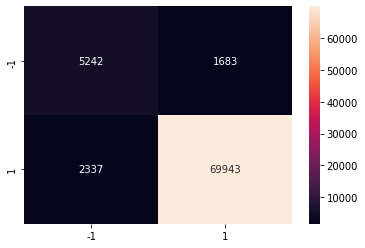

In [ ]:
#cm_sns = pd.crosstab(true_label_list, pred_label_list, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(cm_arr, annot=True, fmt="d", xticklabels=['-1','1'], yticklabels=['-1','1'])
plt.show()

In [ ]:
# ROC-AUC - bert
# Area under curve (AUC)
fpr_keras_bert, tpr_keras_bert, thresholds_keras_bert = roc_curve(pred_label_list, true_label_list)
auc_keras_bert = auc(fpr_keras_bert, tpr_keras_bert)
auc_keras_bert

0.834075460262246

# Get the ROC curve

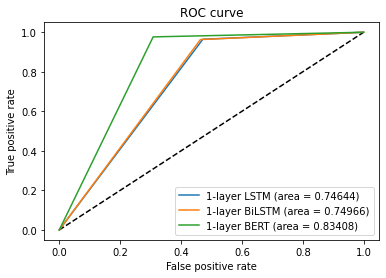

In [ ]:
# get the ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_1lstm, tpr_keras_1lstm, label='1-layer LSTM (area = {:.5f})'.format(auc_keras_1lstm))
plt.plot(fpr_keras_bilstm, tpr_keras_bilstm, label='1-layer BiLSTM (area = {:.5f})'.format(auc_keras_bilstm))
plt.plot(fpr_keras_bert, tpr_keras_bert, label='1-layer BERT (area = {:.5f})'.format(auc_keras_bert))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()